In [ ]:
# %pip install polars
# %pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import polars as pl 
import uuid
import numpy as np

In [2]:
RANDOM_SEED = 42
TOTAL_PATIENTS = 10000
def generate_data(num_patients, random_seed):
    np.random.seed(random_seed)
    data = []
    for _ in range(num_patients):
        # set age 
        age = np.random.randint(18, 90, size = 1)

        # random selection with probabilities
        sex = np.random.choice(
            ["Male","Female","Other","Unknown"], 
            size = 1, 
            p = [0.45, 0.48, 0.02, 0.05]
        )

        # random selection with probabilities
        race = np.random.choice(
            ["White","Black or African American","Asian","American Indian or Alaska Native","Native Hawaiian or Pacific Islander","Other Race","Unknown"], 
            size = 1, 
            p = [0.67, 0.16, 0.08, 0.02, 0.02, 0.01, 0.04]
        )

        # conditional based on gender
        height = np.random.normal(
            loc = 167 + (8 if sex == "Male" else (-5 if sex == "Female" else 0)),
            scale = 6.5 + (0.5 if sex == "Male" else (-0.5 if sex == "Female" else 0))
        )

        # first calculate bmi to derive weight 
        bmi = np.random.normal(
            loc = 27 + (0 if race == "Male" else -0.5) + (0 if age < 50 else 1),
            scale = 5
        )
        weight = bmi * (height / 100.0) ** 2

        # calculate blood pressure readings + heart rate - dependent on age & partially to each other
        systolic_bp = 110 + 0.5*(age - 40) + np.random.normal(loc = 0, scale = 12, size = 1)
        diastolic_bp = 0.6*systolic_bp + np.random.normal(loc = 0, scale = 8, size = 1)
        heart_rate = 75 - 0.05*(systolic_bp-120) + np.random.normal(loc = 0, scale = 7, size = 1)

        # clip blood pressures and HR to realistic values
        systolic_bp = np.clip(systolic_bp, 90, 200)
        diastolic_bp = np.clip(diastolic_bp, 50, 120)
        heart_rate = np.clip(heart_rate, 40, 140)

        row = [int(age[0]), str(sex[0]), str(race[0]), int(height), int(weight), int(systolic_bp[0]), int(diastolic_bp[0]), int(heart_rate[0])]
        data.append(row)
    df = pl.DataFrame(
        data, 
        orient='row',
        schema = {
            "patient_age":pl.Int32, 
            "patient_gender":pl.Utf8, 
            "patient_race":pl.Utf8, 
            "patient_height_cm":pl.Int32, 
            "patient_weight_kg":pl.Int32, 
            "patient_systolic_bp":pl.Int32, 
            "patient_diastolic_bp":pl.Int32, 
            "patient_heart_rate":pl.Int32
        }
    )
    df = df.with_columns(
        pl.when(pl.col("patient_gender") == "Unknown").then(None).otherwise(pl.col("patient_gender")).alias("patient_gender"),
        pl.when(pl.col("patient_race") == "Unknown").then(None).otherwise(pl.col("patient_race")).alias("patient_race"),
        pl.when(pl.lit(np.random.rand(df.height)) < 0.05).then(None).otherwise(pl.col("patient_diastolic_bp")).alias("patient_diastolic_bp"),
        pl.when(pl.lit(np.random.rand(df.height)) < 0.05).then(None).otherwise(pl.col("patient_systolic_bp")).alias("patient_systolic_bp"),
        pl.when(pl.lit(np.random.rand(df.height)) < 0.05).then(None).otherwise(pl.col("patient_heart_rate")).alias("patient_heart_rate")
    )

    return df

In [3]:
data = generate_data(TOTAL_PATIENTS, RANDOM_SEED)


In [4]:
data

patient_age,patient_gender,patient_race,patient_height_cm,patient_weight_kg,patient_systolic_bp,patient_diastolic_bp,patient_heart_rate
i32,str,str,i32,i32,i32,i32,i32
69,null,"""Black or African American""",159,74,127,84,70
38,"""Female""","""White""",158,36,116,67,74
79,"""Male""","""White""",171,82,115,72,71
77,"""Male""","""White""",172,94,113,69,null
21,"""Male""",null,176,96,90,50,81
…,…,…,…,…,…,…,…
81,"""Female""","""White""",163,85,137,76,61
42,null,"""White""",162,43,125,63,68
22,"""Female""","""White""",159,87,92,70,65


In [2]:
feature_names = ['numeric__patient_age' ,'numeric__patient_height_cm',
 'numeric__patient_weight_kg', 'numeric__patient_systolic_bp',
 'numeric__patient_diastolic_bp', 'numeric__patient_heart_rate',
 'categorical__patient_gender_Female', 'categorical__patient_gender_Male',
 'categorical__patient_gender_Other', 'categorical__patient_gender_Unknown',
 'categorical__patient_race_American Indian or Alaska Native',
 'categorical__patient_race_Asian',
 'categorical__patient_race_Black or African American',
 'categorical__patient_race_Native Hawaiian or Pacific Islander',
 'categorical__patient_race_Other Race',
 'categorical__patient_race_Unknown', 'categorical__patient_race_White']

In [3]:
cat_fields = ['patient_gender','patient_race']

for field in cat_fields:
    slice_indices = [i for i,j in enumerate(feature_names) if field in j]
    print(slice_indices)


[6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16]


In [2]:
import os
os.chdir('..')

In [3]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import polars as pl
import os 
import numpy as np

col_list = ['patient_gender','patient_race','patient_height_cm','patient_weight_kg','patient_systolic_bp','patient_diastolic_bp','patient_heart_rate']

original_data = pl.read_parquet('./data/original_data.parquet').select(col_list)
new_data = pl.read_parquet('./data/synthetic_data.parquet').select(col_list)

In [62]:
new_data.select("patient_gender").unique()

patient_gender
str
"""Unknown"""
"""Other"""
"""Female"""
"""Male"""


In [4]:
height_range = (min(original_data.select('patient_height_cm').min().item(), new_data.select('patient_height_cm').min().item()), max(original_data.select('patient_height_cm').max().item(), new_data.select('patient_height_cm').max().item()))
weight_range = (min(original_data.select('patient_weight_kg').min().item(), new_data.select('patient_weight_kg').min().item()), max(original_data.select('patient_weight_kg').max().item(), new_data.select('patient_weight_kg').max().item()))
systolic_range = (min(original_data.select('patient_systolic_bp').min().item(), new_data.select('patient_systolic_bp').min().item()), max(original_data.select('patient_systolic_bp').max().item(), new_data.select('patient_systolic_bp').max().item()))
diastolic_range = (min(original_data.select('patient_diastolic_bp').min().item(), new_data.select('patient_diastolic_bp').min().item()), max(original_data.select('patient_diastolic_bp').max().item(), new_data.select('patient_diastolic_bp').max().item()))
hr_range = (min(original_data.select('patient_heart_rate').min().item(), new_data.select('patient_heart_rate').min().item()), max(original_data.select('patient_heart_rate').max().item(), new_data.select('patient_heart_rate').max().item()))
discrete_categories = [
    ["White","Black or African American","Asian","American Indian or Alaska Native","Native Hawaiian or Pacific Islander","Other Race","Unknown"],
    ["Male","Female","Other","Unknown"]
]

def encode_data(data: pl.DataFrame, height_range = height_range, weight_range = weight_range, systolic_range = systolic_range, diastolic_range = diastolic_range, hr_range = hr_range, discrete_categories = discrete_categories):
    categorical_data = data.select(['patient_race','patient_gender'])
    # numeric_data = data.select(['patient_height_cm','patient_weight_kg','patient_systolic_bp','patient_diastolic_bp','patient_heart_rate'])

    # categorical data
    cat = OneHotEncoder(categories=discrete_categories, handle_unknown='ignore', sparse_output = False).fit_transform(categorical_data)
    # numeric data; split by field to apply custom mins/maxs
    num1 = MinMaxScaler(feature_range=height_range).fit_transform(data.select("patient_height_cm"))
    num2 = MinMaxScaler(feature_range=weight_range).fit_transform(data.select("patient_weight_kg"))
    num3 = MinMaxScaler(feature_range=systolic_range).fit_transform(data.select("patient_systolic_bp"))
    num4 = MinMaxScaler(feature_range=diastolic_range).fit_transform(data.select("patient_diastolic_bp"))
    num5 = MinMaxScaler(feature_range=hr_range).fit_transform(data.select("patient_heart_rate"))
    num = np.hstack((num1,num2,num3,num4,num5))
    return np.hstack((cat, num))

In [5]:
encoded_original_data = encode_data(data = original_data)
encoded_new_data = encode_data(data = new_data)

compressed_original = PCA(n_components = 2).fit_transform(encoded_original_data)
compressed_new = PCA(n_components=2).fit_transform(encoded_new_data)

Text(0.5, 1.0, 'Original (blue) vs. Synthetic (orange): PCA decomposition')

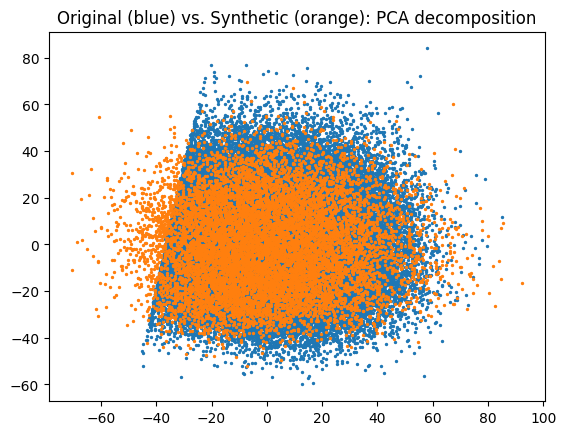

In [10]:
import matplotlib.pyplot as plt 

plt.scatter(compressed_original[:,0], compressed_original[:,1], s = 2);
plt.scatter(compressed_new[:,0], compressed_new[:,1], s = 2);
plt.title("Original (blue) vs. Synthetic (orange): PCA decomposition")